In [1]:
from standard_transform.datasets import v1dd_ds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  # These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.

## Data Access Option 1: setting directory

In [2]:
import sys
from os.path import join as pjoin
import platform

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

In [5]:
def load_cell_df():
    return pd.read_feather(pjoin(data_dir, f"soma_and_cell_type_{mat_version}.feather"))


def load_synapse_df():
    return pd.read_feather(pjoin(data_dir, f"syn_df_all_to_proofread_to_all_{mat_version}.feather"))


def load_proofread_axon_list():
    return np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

## Data Access Option 2: data_io

In [7]:
# This step presumes the suggested data_io module
import sys
from os.path import join as pjoin

# Set the directory to load utility code
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

from data_io import *

#### Step 0. Prepare some useful dataframes

1. Set up a dataframe with cell types and soma depth as well as if cells are proofread or not.
2. Set up the synapse dataframe for querying later.

In [6]:
ct_df = load_cell_df()

In [7]:
ct_df["soma_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "pt_position", ct_df, projection="y"
)
ct_df.soma_depth.head()  # Approximate cell depth from pial surface in microns

0    531.679864
1    572.904495
2    199.288722
3    115.141756
4    464.737835
Name: soma_depth, dtype: float64

In [8]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:

ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [9]:
proofread_ids = load_proofread_axon_list()
ct_df["is_proofread"] = ct_df["pt_root_id"].isin(proofread_ids)

In [10]:
syn_df = load_synapse_df()

# Exercise 1 : Visualizing Connectivity across cell type and space


We want to visualize the combination of the spatial distribution of a neuron's synaptic outputs and where on their target cells they connect.
The depth of a neuron in cortex tells us a lot about its cell type and role in the cortical network.
Where a neuron makes synapses has important implications for its function, for example whether it targets cell bodies, basal dendrites, or apical tufts.
Let's try to visualize these two aspects together — where a neuron makes its synapses and where the cell body is of the target neuron.

**A**.
For root id `864691132729533614`, a basket cell, make a scatter plot with the following requirements:

1. Every dot is a synapse from one cell of interest onto any cell-typed target cell.
2. The x-axis represents the depth of the target cell's *soma*.
3. The y-axis represents the depth of the *synapse*.
4. Each point is colored by the cell type of the target cell. It may be convenient to use two panels if the 

**B**. After you are happy with your plot for that cell, please look at a cell from another cell type, dendrite-targeting interneuron `864691132834855816`. What do you notice about the differences in how these plots appear? What can you infer about how these two different neurons connect to their targets?

**C**. Find and plot the outputs of an excitatory neuron. How, if at all, do they differ from these inhibitory neurons?

## Solution for Question 1. Plot the synaptic outputs of a proofread neuron across space.

Because we want a plot where each dot is a synapse, the primary goal of this section is to create a dataframe where each row is a synapse from a cell of interest and all of the other information is contained in the columns.
Let's start by filtering the synapse dataframe to only include synapses from the cell of interest and then start attaching information about target soma depth, synapse depth, and target cell type.

In [11]:
# Let's start with our basket cell

pre_root_id = ct_df.query('cell_type == "PTC" and is_proofread').iloc[0].pt_root_id
print("Presynaptic root id:", pre_root_id)

Presynaptic root id: 864691132729533614


In [12]:
# Step i. Merge target soma depth onto syn_df:

syn_df_ct = syn_df.query(
    "pre_pt_root_id == @pre_root_id"
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "soma_depth": "soma_depth_post",
            "pt_root_id": "post_pt_root_id",
        }
    ),
    on="post_pt_root_id",
    how="inner",  # We won't plot synapses that aren't onto single neurons, so an inner join is acceptable here.
)

In [13]:
# Add the synapse depth as well

syn_df_ct["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df_ct, projection="y"
)

Let's do a first plot and see what we think

<Axes: xlabel='soma_depth_post', ylabel='synapse_depth'>

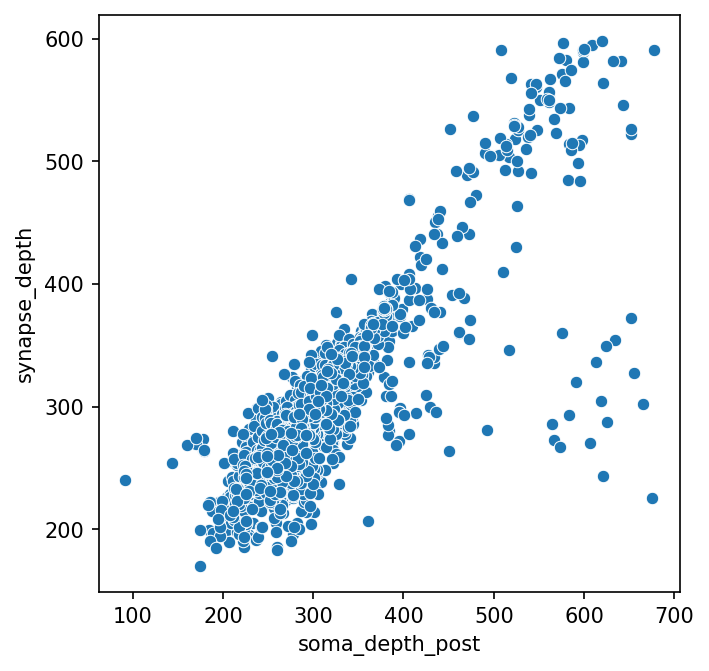

In [14]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(x="soma_depth_post", y="synapse_depth", data=syn_df_ct, ax=ax)

It shows the data, but it's hard to interpret. Let's do a few more things.

1. We need to invert the y-axis to mirror our usual view of cortex, because lower values are actually closer to the surface since this is a depth. We can do this with `ax.invert_yaxis()`.
2. Since both the x and y axis are on the same scale, we should make sure they are the same size with `ax.set_aspect('equal')` and also set the limits to be the same with `ax.set_xlim()` and `ax.set_ylim()`.
3. Let's add a reference at the various layer borders. We can add vertical and horizontal lines with `ax.hlines` and `ax.vlines`.
4. The dots are currently overlapping quite a bit, so we might want to add some transparency with the `alpha` parameter and change the size a bit.

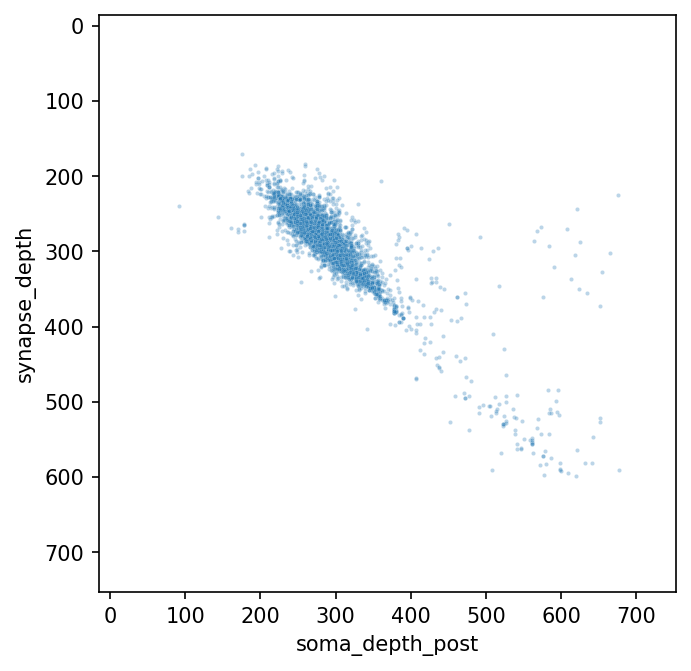

In [15]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=4,
    alpha=0.3,
    legend=False,
)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

Now we can see a lot more structure. What do you notice about where synapses are relative to the depth of their target cell body?
And what do you notice about where synapses are across cortical depth?

We can do a bit better by adding more context:

1. Layer boundaries, so we can have a sense of where synapses and targets are located within the cortical layers.
2. A color palette to distinguish between excitatory and inhibitory neurons.
3. Put a dot where the presynaptic neuron's soma

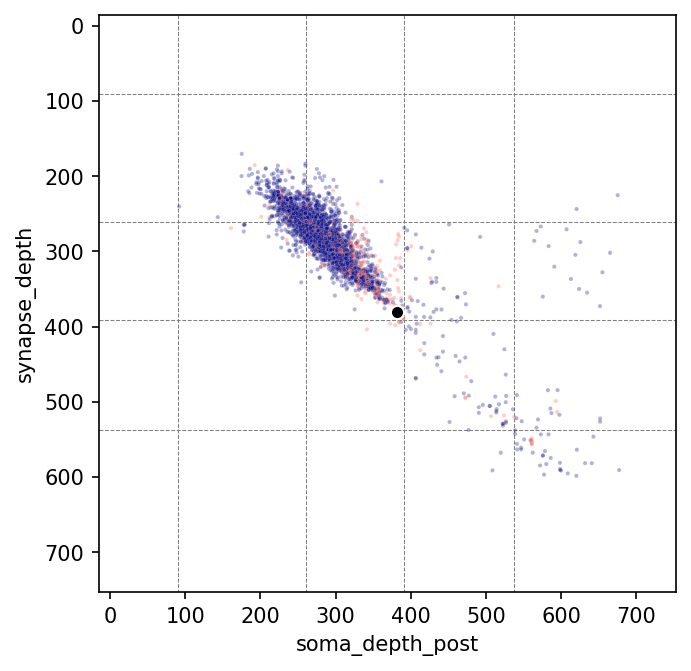

In [16]:
ei_palette = {"E": "navy", "I": "tomato"}

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)


sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=4,
    alpha=0.3,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

# add horizontal and vertical lines where layers are
ax.hlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)  # The `zorder` parameter puts the lines behind the scatter points
ax.vlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)

Now we can see that not only are most of the synapses at about the same depth as the target soma, most of the targets are in the bottom half of layer 2/3 and layer 4 and a few go even deeper.
We can also see that most targets are excitatory.

It is a bit hard to see the inhibitory vs excitatory targets since they overlap so much, so we can go even further and plot E and I in two plots with the same approach. Here, we will make two axes. The first axis will show the excitatory targets and the second axis will show the inhibitory targets.
In each axis, let's plot all synapses in gray, then plot the excitatory or inhibitory synapses on top with color. We can share the same axekks with the `sharey` parameter.

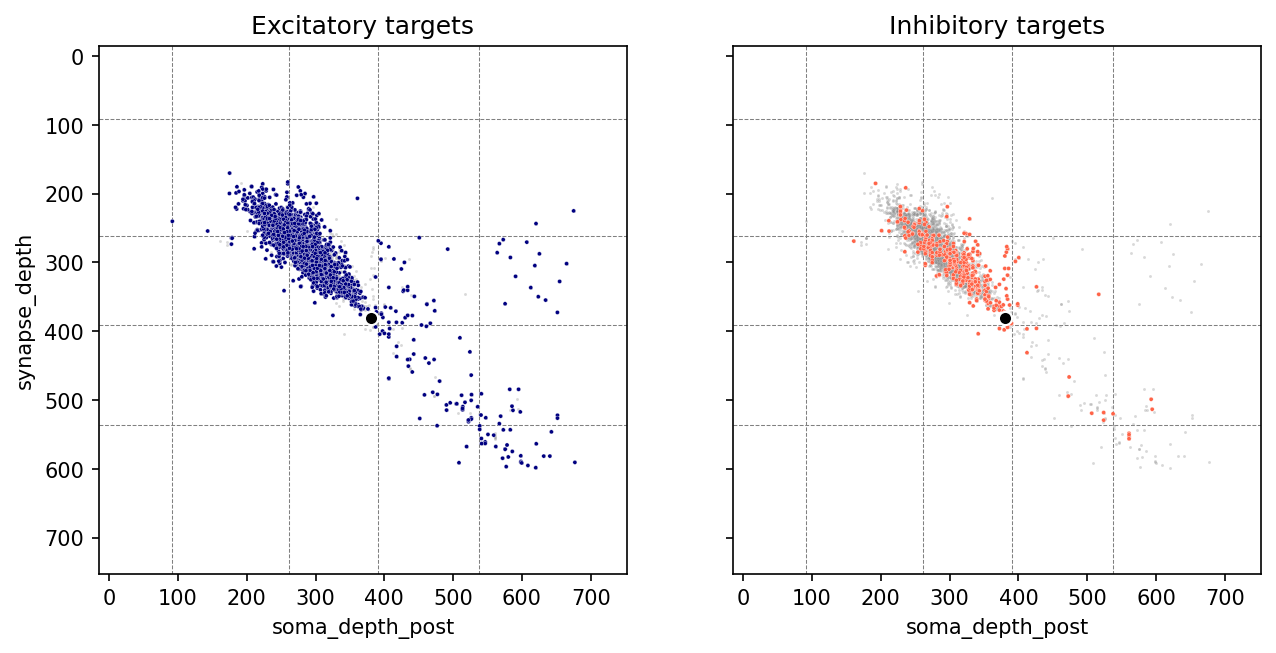

In [17]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, dpi=150, sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "E"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)
ax.set_title("Excitatory targets")
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)


ax = axes[1]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "I"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

ax.set_title("Inhibitory targets")

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.invert_yaxis()  # Note that we only did this one once, otherwise you will invert it back

# add horizontal and vertical lines where layers are
for ax in axes:
    ax.hlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )  # The `zorder` parameter puts the lines behind the scatter points
    ax.vlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )

### Part **B**, a dendrite-targeting cell

Now let's try the same code with a different root id from a different cell type, like a dendrite targeting cell.

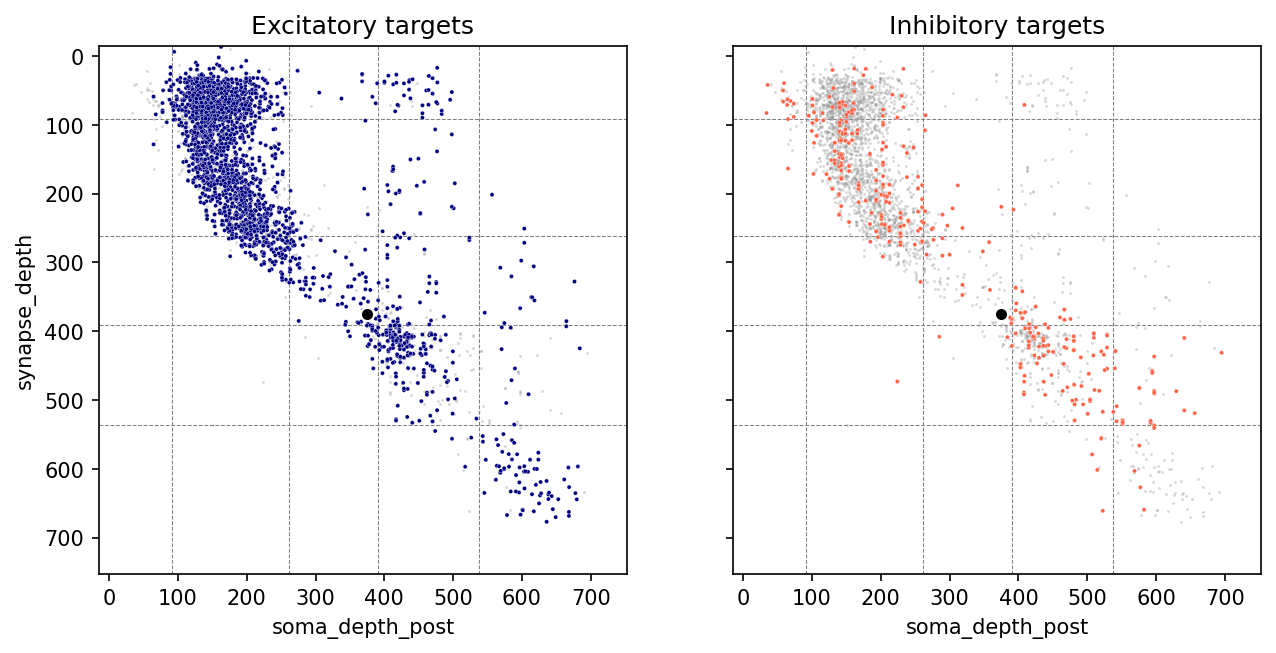

In [18]:
pre_root_id = 864691132834855816
# pre_root_id = ct_df.query('cell_type == "DTC" and is_proofread').iloc[20].pt_root_id

syn_df_ct = syn_df.query("pre_pt_root_id == @pre_root_id").merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "soma_depth": "soma_depth_post",
            "pt_root_id": "post_pt_root_id",
        }
    ),
    on="post_pt_root_id",
    how="inner",
)
syn_df_ct["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df_ct, projection="y"
)

fig, axes = plt.subplots(figsize=(10, 5), ncols=2, dpi=150, sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "E"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)
ax.set_title("Excitatory targets")
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax = axes[1]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "I"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

ax.set_title("Inhibitory targets")

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.invert_yaxis()

# add horizontal and vertical lines where layers are
for ax in axes:
    ax.hlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )  # The `zorder` parameter puts the lines behind the scatter points
    ax.vlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )

Not that this cell's synapses are much farther from the diagonal line, indicating that the synapse depth is quite different than the soma depth. In particular, many synapses are up in layer 1, suggesting it makes many synapses onto the apical tufts, particularly of neurons in layer 2/3.

## Part **C**, an excitatory neuron

We can just copy and paste from our previous panels (or, if we are feeling adventurous, we can create a function to do the same)

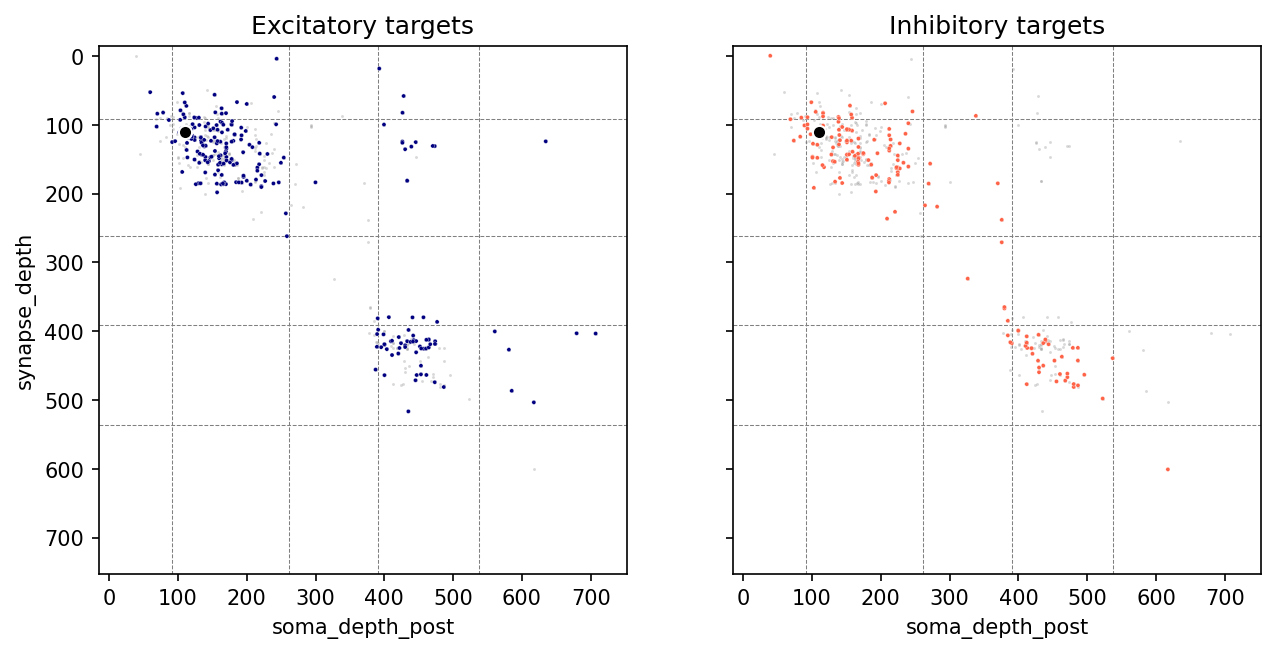

In [19]:
pre_root_id = ct_df.query('cell_type == "L2-IT" and is_proofread').iloc[1].pt_root_id

syn_df_ct = syn_df.query("pre_pt_root_id == @pre_root_id").merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "soma_depth": "soma_depth_post",
            "pt_root_id": "post_pt_root_id",
        }
    ),
    on="post_pt_root_id",
    how="inner",
)
syn_df_ct["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df_ct, projection="y"
)

fig, axes = plt.subplots(figsize=(10, 5), ncols=2, dpi=150, sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "E"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)
ax.set_title("Excitatory targets")
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax = axes[1]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "I"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

ax.set_title("Inhibitory targets")

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.invert_yaxis()

# add horizontal and vertical lines where layers are
for ax in axes:
    ax.hlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )  # The `zorder` parameter puts the lines behind the scatter points
    ax.vlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )

# Question 2:

Knowing that depth matters a great deal, let's now visualize how neurons of different depths connect to one another.
This will be like an adacency matrix, except instead of giving each connected pair of neurons a row and column, we will plot it at their depths.
One nice thing about this plot is that, while cell typing can sometimes yield borderline or unclear cases, the depth of a cell is concrete and we can infer useful information about the laminar organization of the cortical circuit directly.

**A**. Make a scatterplot where:
1. Each dot is a connection from one proofread presynaptic neuron to one proofread postsynaptic neuron.
2. The x-axis represents the depth of the presynaptic neuron's soma.
3. The y-axis represents the depth of the postsynaptic neuron's soma.
4. Points are sized by the strength of the synaptic connection.

As before, add layer boundaries context.

**B**. Next, add cell type information. Instead of one scatter plot, make four plots, where one plot corresponds to E->E connections, one for E->I connections, one for I->E connections, and one for I->I connections.

If you want to see what, if anything, changes when including *all* postsynaptic neurons (instead of only proofread), feel free to do that as well as a stretch goal.

#### Solution for Question 2:

As before, the first step is to make a dataframe where each row is a connection, and all of these values are available as different columns.

In [20]:
# Mark proofread neurons in the synapse dataframe so we can filter out everything else
syn_df = load_synapse_df()
syn_df["pre_proofread"] = syn_df["pre_pt_root_id"].isin(proofread_ids)
syn_df["post_proofread"] = syn_df["post_pt_root_id"].isin(proofread_ids)

In [21]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses and their summed synapse size.

connectivity_df = (
    syn_df.query("pre_proofread and post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"))
    .reset_index()
)

connectivity_df.head()

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size
0  864691132534275418  864691132619649223             1      2620
1  864691132534275418  864691132656860272             1       898
2  864691132534275418  864691132659029623             3      3828
3  864691132534275418  864691132663192644             1      4488
4  864691132534275418  864691132663898692             1      1556

In [22]:
# To merge depth information, we can merge with the cell type dataframe like so. Renaming the columns ahead of time just keeps things more simple, but is not necessary.

connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "soma_depth": "soma_depth_pre"}
    ),
    on="pre_pt_root_id",
)

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size  \
0      864691132534275418  864691132619649223             1      2620   
1      864691132534275418  864691132656860272             1       898   
2      864691132534275418  864691132659029623             3      3828   
3      864691132534275418  864691132663192644             1      4488   
4      864691132534275418  864691132663898692             1      1556   
...                   ...                 ...           ...       ...   
92157  864691133313665616  864691132852413955             2      2673   
92158  864691133313665616  864691132973162293             1      2758   
92159  864691133313665616  864691132980861372             2      2643   
92160  864691133313665616  864691133121872229             1       502   
92161  864691133313665616  864691133313636944             1       286   

       soma_depth_pre  
0          307.933654  
1          307.933654  
2          307.933654  
3          307.933654  
4          307.933654  
...               ...  
92157      608.639135  
92158      608.639135  
92159      608.639135  
92160      608.639135  
92161      608.639135  

[92162 rows x 5 columns]

In [23]:
# In fact, we want both pre and post synaptic depth information as well as cell type information, so let's do the more complicated version:

connectivity_depth_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

connectivity_depth_df.head(10)

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size  \
0  864691132534275418  864691132619649223             1      2620   
1  864691132534275418  864691132656860272             1       898   
2  864691132534275418  864691132659029623             3      3828   
3  864691132534275418  864691132663192644             1      4488   
4  864691132534275418  864691132663898692             1      1556   
5  864691132534275418  864691132666054744             1      4965   
6  864691132534275418  864691132689698824             1      1436   
7  864691132534275418  864691132700001158             1       631   
8  864691132534275418  864691132714139653             1       270   
9  864691132534275418  864691132739485851             1      3425   

   soma_depth_pre ei_pre cell_type_pre  soma_depth_post ei_post cell_type_post  
0      307.933654      E         L4-IT       439.655263       I            DTC  
1      307.933654      E         L4-IT       350.927029       I            DTC  
2      307.933654      E         L4-IT       343.542750       I            DTC  
3      307.933654      E         L4-IT       469.967499       E          L5-ET  
4      307.933654      E         L4-IT       597.525035       I            PTC  
5      307.933654      E         L4-IT       455.900796       E          L5-ET  
6      307.933654      E         L4-IT       411.958389       I            DTC  
7      307.933654      E         L4-IT       419.385789       E          L5-ET  
8      307.933654      E         L4-IT       470.241537       I            DTC  
9      307.933654      E         L4-IT       428.037770       E          L5-ET

Now that we have a connection dataframe with all of our information, we can construct the scatterplot similar to the above.

Since there is a lot of data here, let's split it out by coarse cell types. Start with E/E and let's scale connection size by the number of synapses.

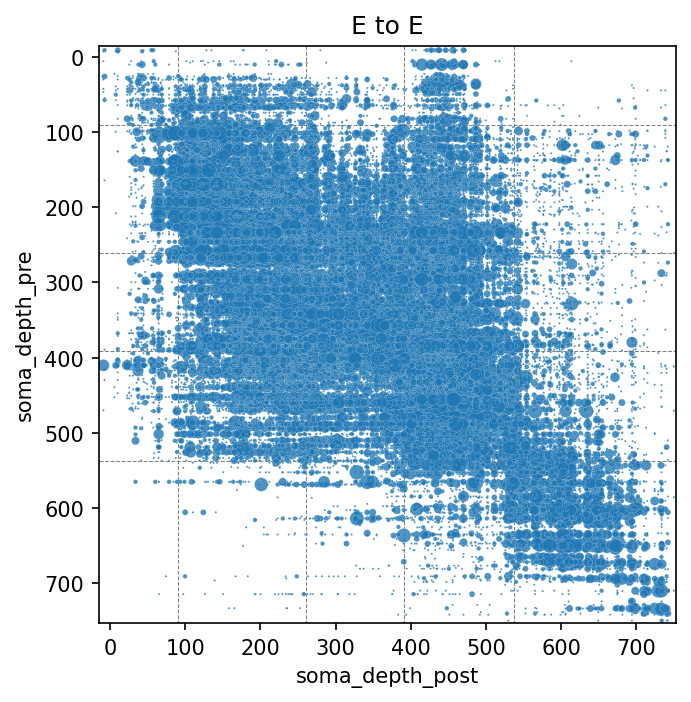

In [24]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(
    x="soma_depth_post",
    y="soma_depth_pre",
    data=connectivity_depth_df,
    ax=ax,
    size="num_synapses",
    sizes=(1, 50),
    size_norm=(1, 15),  # Sets the value range mapping to the range in "sizes".
    legend=False,
    alpha=0.8,
)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

ax.set_title("E to E")

# add horizontal and vertical lines where layers are
ax.hlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)  # The `zorder` parameter puts the lines behind the scatter points
ax.vlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)

## Part B.

This looks great, but it's too much information to tell at once!
Now let's split out E->I, E->E, I->E, and I->I into four separate plots and color things accordingly.

In [25]:
connectivity_depth_df.query('ei_pre == "I" and ei_post == "I"')

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size  \
86     864691132536286810  864691132572190492             2      1502   
87     864691132536286810  864691132574470970             3      2071   
94     864691132536286810  864691132640160656             1       773   
96     864691132536286810  864691132644866746             1      1330   
97     864691132536286810  864691132647454284             7      7830   
...                   ...                 ...           ...       ...   
91992  864691133311980112  864691132875841271             1      2633   
91997  864691133311980112  864691132939082462            10     11126   
91998  864691133311980112  864691133010159312             1       163   
92000  864691133311980112  864691133049361508             1       595   
92001  864691133311980112  864691133311300176             3      1645   

       soma_depth_pre ei_pre cell_type_pre  soma_depth_post ei_post  \
86         471.127803      I           DTC        99.899983       I   
87         471.127803      I           DTC       528.755799       I   
94         471.127803      I           DTC        65.218348       I   
96         471.127803      I           DTC       334.302352       I   
97         471.127803      I           DTC       543.242831       I   
...               ...    ...           ...              ...     ...   
91992      131.243102      I           ITC       480.905183       I   
91997      131.243102      I           ITC       150.760048       I   
91998      131.243102      I           ITC       203.403149       I   
92000      131.243102      I           ITC       233.618786       I   
92001      131.243102      I           ITC       295.948108       I   

      cell_type_post  
86               PTC  
87               DTC  
94               STC  
96               PTC  
97               DTC  
...              ...  
91992            PTC  
91997            DTC  
91998            ITC  
92000            PTC  
92001            PTC  

[22022 rows x 10 columns]

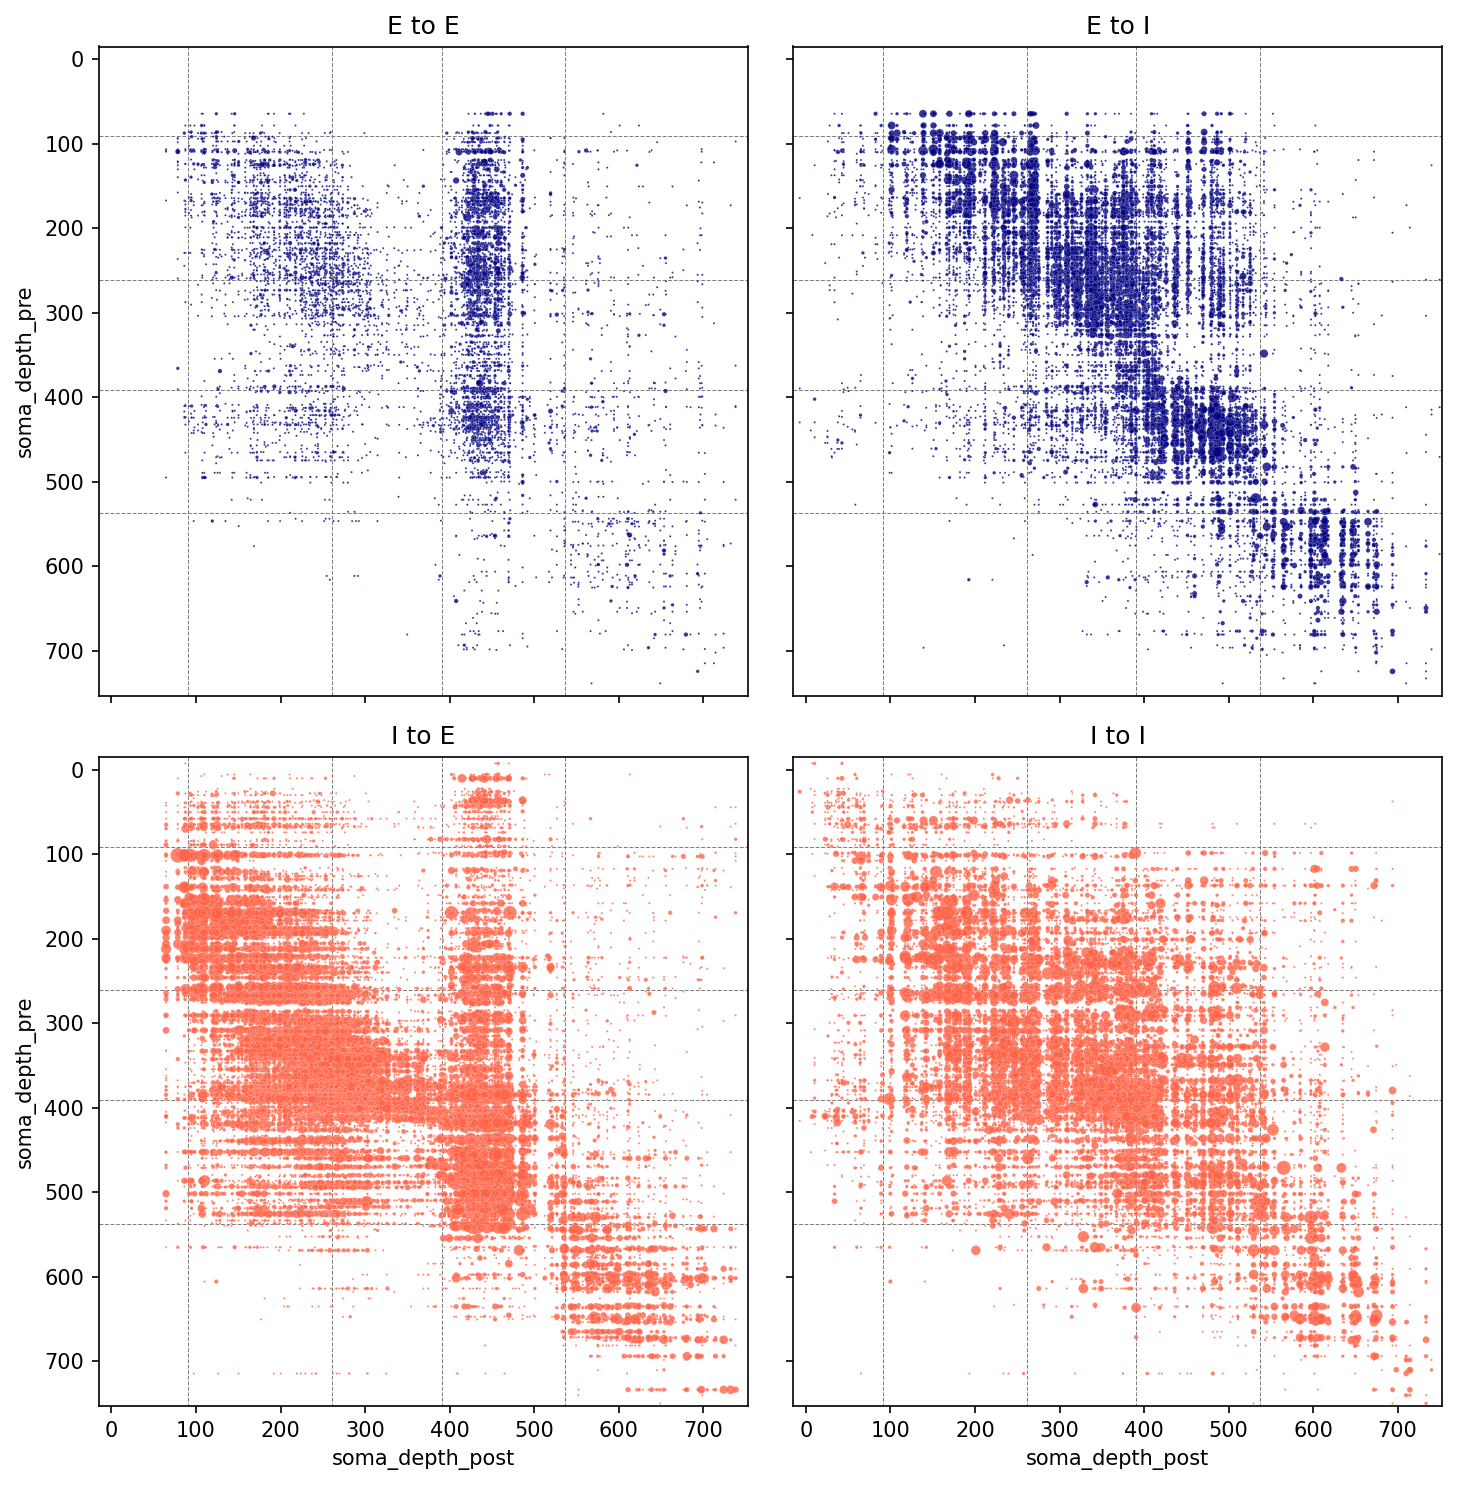

In [26]:
fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ct_category = ["E", "I"]
for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        pre_cat = ct_category[pre_ind]
        post_cat = ct_category[post_ind]
        sns.scatterplot(
            x="soma_depth_post",
            y="soma_depth_pre",
            data=connectivity_depth_df.query(
                "ei_pre == @pre_cat and ei_post == @post_cat"
            ),
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            hue="ei_pre",
            palette=ei_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{pre_cat} to {post_cat}")

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()


## For fun

What if we do the same thing, but now drop the requirement that the postsynaptic neuron is proofread.

In [27]:
connectivity_df = (
    syn_df.query("pre_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"))
    .reset_index()
)

connectivity_df.head()

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size
0  864691132534275418  864691128492669180             1       373
1  864691132534275418  864691128570869823             1       249
2  864691132534275418  864691128613643273             1       258
3  864691132534275418  864691128614771842             1      1097
4  864691132534275418  864691128637189889             1       923

We can use the same merge approach, since everything in our cell type table is already definitely a single soma with depth and cell typing.

In [28]:
# In fact, we want both pre and post synaptic depth information as well as cell type information, so let's do the more complicated version:

connectivity_depth_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

connectivity_depth_df.head(10)

pre_pt_root_id     post_pt_root_id  num_synapses  sum_size  \
0  864691132534275418  864691132545971778             1       839   
1  864691132534275418  864691132555074569             1      1363   
2  864691132534275418  864691132557993993             2      4299   
3  864691132534275418  864691132559315940             2      1683   
4  864691132534275418  864691132565101518             1      1667   
5  864691132534275418  864691132574637882             1       658   
6  864691132534275418  864691132574811706             1      1589   
7  864691132534275418  864691132578930196             1       511   
8  864691132534275418  864691132578972946             1      1948   
9  864691132534275418  864691132579028498             1      1420   

   soma_depth_pre ei_pre cell_type_pre  soma_depth_post ei_post cell_type_post  
0      307.933654      E         L4-IT       367.944246       E          L5-IT  
1      307.933654      E         L4-IT       188.047441       E          L3-IT  
2      307.933654      E         L4-IT       340.856253       I            PTC  
3      307.933654      E         L4-IT       100.129357       I            ITC  
4      307.933654      E         L4-IT       384.508648       I            PTC  
5      307.933654      E         L4-IT       357.166861       I            PTC  
6      307.933654      E         L4-IT       340.933359       I            PTC  
7      307.933654      E         L4-IT       481.172719       E          L5-ET  
8      307.933654      E         L4-IT       298.363686       E          L4-IT  
9      307.933654      E         L4-IT       333.225275       E          L4-IT

For visualization, the same thing will work but we might want to adjust some of the plotting parameters to improve clarity and presentation. This could include changing point sizes, colors, or transparency levels.

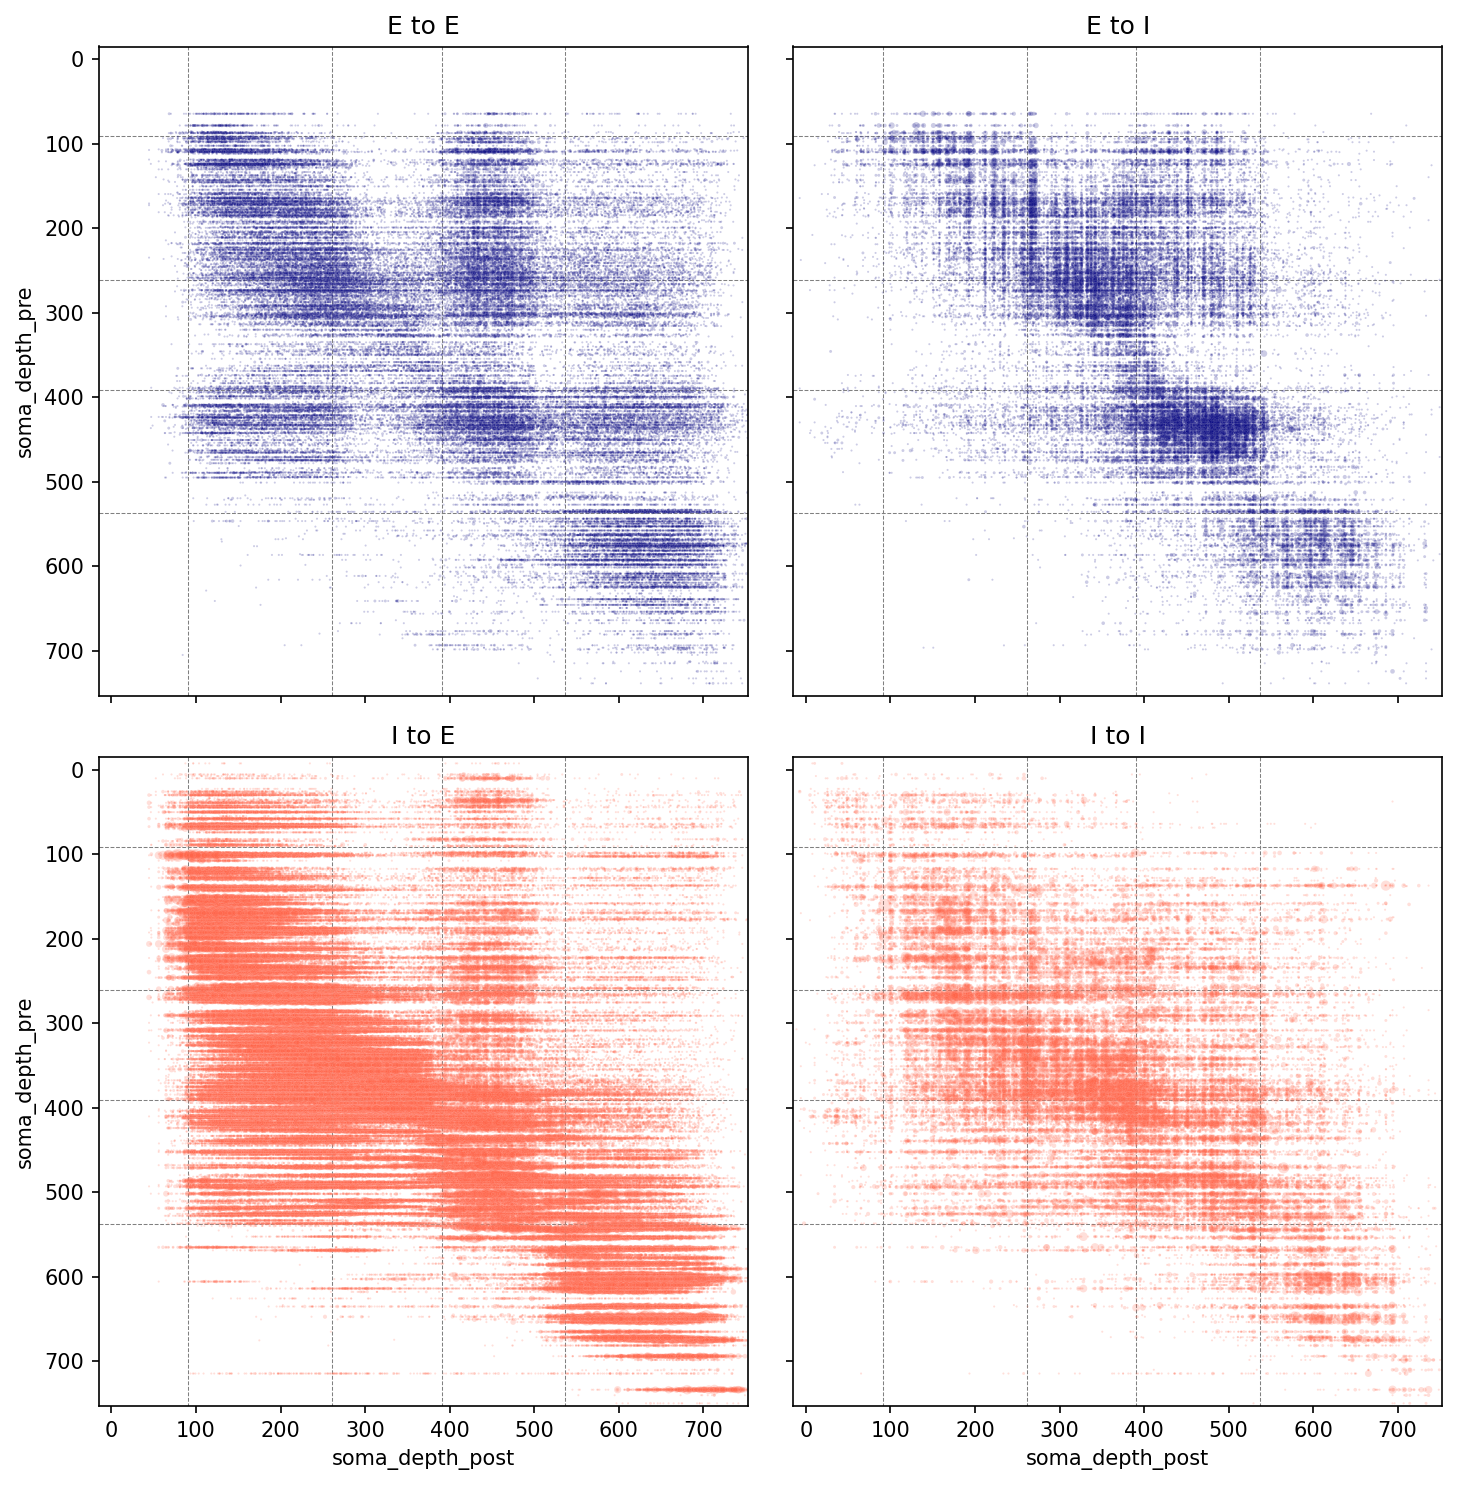

In [29]:
fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ct_category = ["E", "I"]
for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        pre_cat = ct_category[pre_ind]
        post_cat = ct_category[post_ind]
        sns.scatterplot(
            x="soma_depth_post",
            y="soma_depth_pre",
            data=connectivity_depth_df.query(
                "ei_pre == @pre_cat and ei_post == @post_cat"
            ),
            ax=ax,
            size="num_synapses",
            sizes=(1, 40),
            size_norm=(1, 40),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            hue="ei_pre",
            palette=ei_palette,
            alpha=0.2,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{pre_cat} to {post_cat}")

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
